# Semantic analysis of sexism in French Rap using word embeddings

Natural Language Processing for the Social Sciences

Matteo Larrode, MSc Social Data Science

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import wandb
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import re

from utils.cleaning_helpers import *
from utils.visualisations_helpers import *
from utils.analysis_helpers import *

set_visualization_style()

viridis = plt.get_cmap('viridis_r', 6) 

In [ ]:
# Data is from 2024 ACL-SRW paper "A Computational Analysis and Exploration of Linguistic Borrowings in French Rap Lyrics" by Lucas Zurbuchen and Rob Voigt.
# Paper: https://aclanthology.org/2024.acl-srw.27.pdf
# Source: https://github.com/ljz112/CLResearch/tree/main/dataEntries

# Download the data from the GitHub repository & create csv files:
# python data_preprocessing.py
# Or to skip the download:
# python data_preprocessing.py --skip-download

In [8]:
# Load the data
songs_df = pd.read_pickle('data/processed_french_rap_songs.pkl')

songs_df.info()
print(type(songs_df['cleaned_lyrics'].iloc[0]))
print(songs_df['cleaned_lyrics'].iloc[0][:100])

<class 'pandas.core.frame.DataFrame'>
Index: 8208 entries, 0 to 11616
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              8208 non-null   int64 
 1   name            8208 non-null   object
 2   artists         8208 non-null   object
 3   releaseDate     8208 non-null   object
 4   popularity      8208 non-null   int64 
 5   lyrics          8208 non-null   object
 6   cleaned_lyrics  8208 non-null   object
 7   is_french       8208 non-null   bool  
 8   year            8208 non-null   int64 
 9   decade          8208 non-null   object
dtypes: bool(1), int64(3), object(6)
memory usage: 649.3+ KB
<class 'list'>
['moi', 'je', 'sais', 'ce', 'que', 'veux', 'tu', 'sais', 'est', 'quoi', 'mon', 'but', 'etre', 'un', 'putain', 'de', 'bourgeois', 'gagner', 'du', 'ble', 'rien', 'glander', 'je', 'ne', 'veux', 'surtout', 'pas', 'retourner', 'ou', 'etais', 'je', 'ne', 'veux', 'plus', 'cirer', 'les', 'pompes', 'u

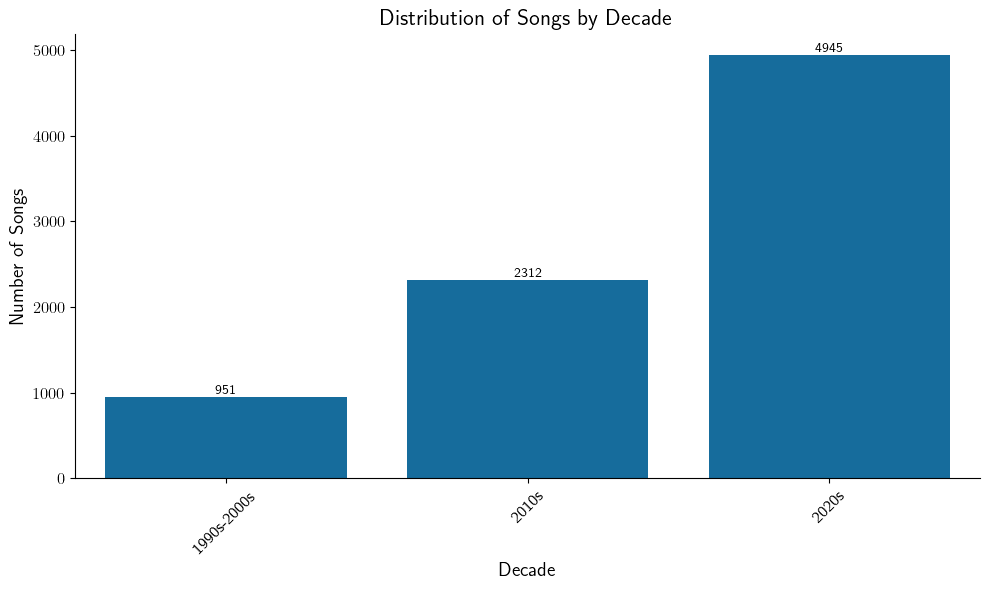

In [13]:
# Check number of songs per decade
plt.figure(figsize=(10, 6))
decade_counts = songs_df['decade'].value_counts().sort_index()
sns.barplot(x=decade_counts.index, y=decade_counts.values)
# Add number of songs on top of each bar
for i, count in enumerate(decade_counts.values):
    plt.text(i, count + 5, str(count), ha='center', va='bottom')
plt.title('Distribution of Songs by Decade')
plt.xlabel('Decade')
plt.ylabel('Number of Songs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Word Embedding Training

Code inspired from Schmahl, K. G., Viering, T., Makrodimitris, S., Jahfari, A. N., Tax, D., & Loog, M. (2020). Is Wikipedia succeeding in reducing gender bias? Assessing changes in gender bias in Wikipedia using word embeddings. NLPCSS. https://doi.org/10.18653/V1/2020.NLPCSS-1.11

https://gitlab.com/kschmahl/wikipedia-gender-bias-over-time/

In [9]:
# Initialize W&B
wandb.init(project="french-rap-word-embeddings", name="simple-training")

# Group songs by decade
decades = songs_df['decade'].unique()
print(f"Decades in dataset: {decades}")

# Define parameters
vector_size = 100
window = 10
workers = 4
min_count = 5
iterations = 5
sg = 1  # Skip-gram model
seed = 42

# Train a model for each decade
for decade in decades:
    print(f"\nTraining model for {decade}...")
    
    # Get songs for this decade
    decade_songs = songs_df[songs_df['decade'] == decade]
    print(f"Number of songs: {len(decade_songs)}")
    
    # Use pre-tokenized lyrics if available
    if 'cleaned_lyrics' in decade_songs.columns:
        # Filter out any None or NaN values
        corpus = [tokens for tokens in decade_songs['cleaned_lyrics'].tolist() if tokens]
    else:
        print("Warning: No cleaned_lyrics found.")
        # Terminate the loop
        continue
    
    print(f"Corpus size: {len(corpus)} songs")
    
    # Create output directory
    output_dir = f'models/{decade}'
    os.makedirs(output_dir, exist_ok=True)
    
    # Train the model
    model = Word2Vec(
        sentences=corpus,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        workers=workers,
        epochs=iterations,
        sg=sg,
        seed=seed
    )
    
    # Log basic info to W&B
    wandb.log({
        "decade": decade,
        "num_songs": len(corpus),
        "vocab_size": len(model.wv.index_to_key)
    })
    
    # Save the model
    model_path = f'{output_dir}/rap_{decade}_model'
    model.save(model_path)
    print(f"Model saved to {model_path}")
    
    # Save vocabulary dictionary
    vocab_dict = {word: index for index, word in enumerate(model.wv.index_to_key)}
    with open(f'{model_path}-vocab.pkl', 'wb') as f:
        pickle.dump(vocab_dict, f)
    
    # Save vectors in numpy format
    np.save(f'{model_path}-vectors.npy', model.wv.vectors)

# Train model on the entire corpus
print("\nTraining model on all decades combined...")

# Combine all corpora
all_corpus = []
for decade in decades:
    decade_songs = songs_df[songs_df['decade'] == decade]
    if 'cleaned_lyrics' in decade_songs.columns:
        decade_corpus = [tokens for tokens in decade_songs['cleaned_lyrics'].tolist() if tokens]
        all_corpus.extend(decade_corpus)

print(f"Combined corpus size: {len(all_corpus)} songs")

# Create output directory for combined model
output_dir = 'models/all'
os.makedirs(output_dir, exist_ok=True)

# Train the combined model
all_model = Word2Vec(
    sentences=all_corpus,
    vector_size=vector_size,
    window=window,
    min_count=min_count,
    workers=4,
    epochs=iterations,
    sg=sg,
    seed=seed
)

# Log basic info to W&B
wandb.log({
    "decade": "all",
    "num_songs": len(all_corpus),
    "vocab_size": len(all_model.wv.index_to_key)
})

# Save the combined model
model_path = f'{output_dir}/rap_all_decades_model'
all_model.save(model_path)
print(f"Combined model saved to {model_path}")

# Save vocabulary dictionary
vocab_dict = {word: index for index, word in enumerate(all_model.wv.index_to_key)}
with open(f'{model_path}-vocab.pkl', 'wb') as f:
    pickle.dump(vocab_dict, f)

# Save vectors in numpy format
np.save(f'{model_path}-vectors.npy', all_model.wv.vectors)

# Finish the W&B run
wandb.finish()

print("Training complete!")

Decades in dataset: ['1990s-2000s' '2010s' '2020s']

Training model for 1990s-2000s...
Number of songs: 951
Corpus size: 951 songs
Model saved to models/1990s-2000s/rap_1990s-2000s_model

Training model for 2010s...
Number of songs: 2312
Corpus size: 2312 songs
Model saved to models/2010s/rap_2010s_model

Training model for 2020s...
Number of songs: 4945
Corpus size: 4945 songs
Model saved to models/2020s/rap_2020s_model

Training model on all decades combined...
Combined corpus size: 8208 songs
Combined model saved to models/all/rap_all_decades_model


num_songs,▁▂▅█
vocab_size,▁▂▅█
decade,all
num_songs,8208
vocab_size,24857


Training complete!


## Word Embedding Validation

In [12]:
models = load_models()

Loaded model: all
Loaded model: 2020s
Loaded model: 2010s
Loaded model: 1990s-2000s


In [19]:
# Check most similar words to 'voiture' in each model
print("\n--- Most similar words to 'voiture' ---")
for model_name, model in models.items():
    print(f"\nModel: {model_name}")
    try:
        similar_words = most_similar_words(model, 'voiture', topn=5)
        for word, similarity in similar_words:
            print(f"  {word}: {similarity:.4f}")
    except KeyError:
        print(f"  'voiture' not in vocabulary")


--- Most similar words to 'voiture' ---

Model: all
  allemande: 0.6967
  volee: 0.6902
  neuve: 0.6609
  sequentielle: 0.6601
  garee: 0.6273

Model: 2020s
  neuve: 0.7098
  allemande: 0.6800
  schumacher: 0.6231
  garee: 0.6107
  ouvreuse: 0.6104

Model: 2010s
  relais: 0.7144
  kilometree: 0.7142
  boboch: 0.6167
  banalisee: 0.6079
  allemande: 0.6042

Model: 1990s-2000s
  georges: 0.7732
  bouteille: 0.7697
  belier: 0.7667
  coffre: 0.7640
  robe: 0.7627


In [21]:
# Compare specific word pairs across models
print("\n--- Word pair similarities across models ---")
word_pairs = [
    ('mec', 'beau'), 
    ('meuf', 'belle'),
    ('mec', 'fort'), 
    ('meuf', 'forte'),
    ('mec', 'travail'), 
    ('meuf', 'travail'), 
    ('mec', 'maison'),
    ('meuf', 'maison')
]

pair_results = compare_word_pairs(models, word_pairs)
for model_name, pairs in pair_results.items():
    print(f"\nModel: {model_name}")
    for pair, similarity in pairs.items():
        print(f"  {pair}: {similarity:.4f}")


--- Word pair similarities across models ---

Model: all
  mec-beau: 0.4108
  meuf-belle: 0.4517
  mec-fort: 0.4395
  meuf-forte: 0.3217
  mec-travail: 0.3740
  meuf-travail: 0.3069
  mec-maison: 0.2220
  meuf-maison: 0.3195

Model: 2020s
  mec-beau: 0.3360
  meuf-belle: 0.4009
  mec-fort: 0.3602
  meuf-forte: 0.3964
  mec-travail: 0.2293
  meuf-travail: 0.1922
  mec-maison: 0.1853
  meuf-maison: 0.3127

Model: 2010s
  mec-beau: 0.3109
  meuf-belle: 0.3677
  mec-fort: 0.2276
  meuf-forte: 0.4131
  mec-travail: 0.2821
  meuf-travail: 0.3431
  mec-maison: 0.0828
  meuf-maison: 0.3174

Model: 1990s-2000s
  mec-beau: 0.5037
  meuf-belle: 0.6335
  mec-fort: 0.3053
  meuf-forte: 0.4606
  mec-travail: 0.3935
  meuf-travail: 0.2747
  mec-maison: 0.4153
  meuf-maison: 0.5631


## Gender Stereotypes Analysis